In [1]:
%matplotlib notebook

import numpy as np
import os

from gf321_utils import marker_utils
from gf321_utils import bvh_utils
from gf321_utils import plot_utils

In [2]:
#Import data
data_filepath = 'neural_lbs_data/'
joints = np.load(data_filepath + 'all_joints_aug.npy')
markers = np.load(data_filepath + 'all_markers_aug.npy')

In [3]:
#Make local stuff
root_tfs = bvh_utils.create_local_tfs_root(joints)
markers_local = marker_utils.make_markers_local(markers,root_tfs)
joints_local = bvh_utils.make_joints_local(joints)

In [4]:
#NB Should eventually include this within the DogDenoiser class (NN etc)

def corrupt(markers, occlude_std=0.1, shift_std=0.1, max_shift=500):
    '''
    Corruption function following Holden's corruption function.
    
    Expects input markers to have shape (frame_num, marker_num, 3)
    NB markers must be in a local frame (whatever that means for the given system)
    
    Reads markers and outputes markers with noise(shift) and occlusion(sent to origin)
    Using the default settings from Holden noting that max_shift = 'beta' = 50cm = 500(mm)
    '''
    
    frame_num = markers.shape[0]
    marker_num = markers.shape[1]
    
    #Sample probabilities at which to occlude/shift
    occlude_prob = np.random.normal(0, occlude_std, frame_num)
    shift_prob = np.random.normal(0, shift_std, frame_num)
    
    #Sample using clipped probabilities, and reshape appropriately
    occlusions = np.zeros((frame_num,marker_num))
    for fr in range(frame_num):
        occlusions[fr] = np.random.binomial(1, min(abs(occlude_prob[fr]), 2*occlude_std), marker_num)
    occlusions = occlusions.reshape((frame_num, marker_num))
    
    shifts = np.zeros((frame_num,marker_num))
    for fr in range(frame_num):
        shifts[fr] = np.random.binomial(1, min(abs(shift_prob[fr]), 2*shift_std), marker_num)
    shifts = shifts.reshape((frame_num, marker_num))
    
    #Sample the magnitude by which to shift each marker
    shift_mags = np.random.uniform(-max_shift, max_shift, frame_num*marker_num*3)
    shift_mags = shift_mags.reshape((frame_num, marker_num, 3))
    
    #Shift markers by shifting markers by sampled shift magnitude if the relevant entry in shifts is 1
    markers = markers + np.einsum('ij,ijk->ijk', shifts, shift_mags)
    #Occlude markers by sending occluded markers to origin
    markers = np.einsum('ijk,ij->ijk', markers, 1 - occlusions)
    
    return markers  

<IPython.core.display.Javascript object>


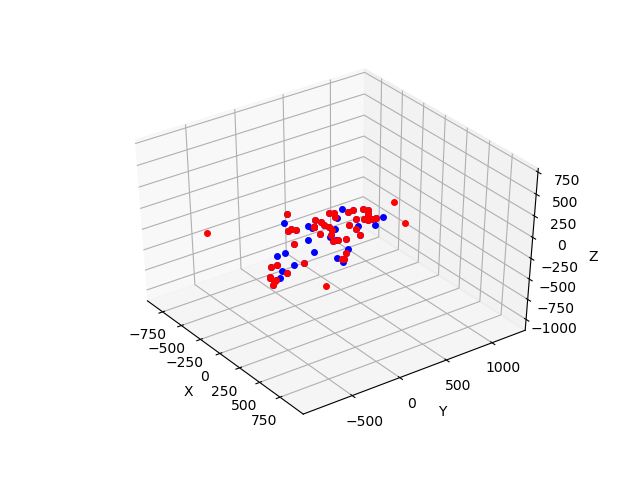

In [5]:
corrupted_markers = corrupt(markers_local)
ani = plot_utils.AnimatePlot()
ani.animated_plot(markers_local, corrupted_markers)

1

array([0, 0, 1, 1])